In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from numba import jit
import numpy as np
import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
def calc_ema_per_event_c(v, c, reset_flags=None):
    if reset_flags is None:
        reset_flags = [False]*len(v)
    # denote averaging_window = 1 / c
    ema = np.nan * v
    ema[0] = v[0]
    for i in range(1,len(v)):
        if reset_flags[i]:
            ema[i] = v[i]
        else:
            ema[i] = ema[i-1] * (1-c) + v[i] * c
    return ema

@jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit
def calc_ema_per_event(v, span, reset_flags=None):
    if reset_flags is None:
        reset_flags = np.array([False]*len(v))
    c = 2 / (1+span) 
    # denote averaging_window = 1 / c = (1-span)/2
    ema = np.nan * v
    ema[0] = v[0]
    for i in range(1,len(v)):
        if reset_flags[i]:
            ema[i] = v[i]
        else:
            ema[i] = ema[i-1] * (1-c) + v[i] * c
    return ema

@jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit
def calc_ema_temporal(v, t, halflife, reset_flags=None):
    if reset_flags is None:
        reset_flags = np.array([False]*len(v))
    ema = np.nan * v
    ema[0] = v[0]
    tau = halflife / np.log(2)
    c_list = []
    dt_list = []
    for i in range(1,len(v)):
        dt = max(0,t[i] - t[i-1])
        dt_list.append(dt)
        c = 1. - np.exp(-dt/tau)
        c_list.append(c)
        if reset_flags[i]:
            ema[i] = v[i]
        else:
            ema[i] = ema[i-1] *(1 - c) + v[i] * c
    return ema


In [3]:
def calculate_bb(bollinger_band_period=20, column=None, df=None):
    df['SMA'] = df[f'{column}'].rolling(window=bollinger_band_period).mean()
    df[f'{column}_{bollinger_band_period}_BB_up'] = df['SMA'] + 2 * df[column].rolling(window=bollinger_band_period).std()
    df[f'{column}_{bollinger_band_period}_BB_down'] = df['SMA'] - 2 * df[column].rolling(window=bollinger_band_period).std()
    df = df.drop(columns=['SMA'])
    return df

def calculate_RSI(rsi_period=14, column=None, df=None):
    delta = df[column].diff()
    gain, loss = delta.copy(), delta.copy()
    gain[gain < 0] = 0
    loss[loss > 0] = 0
    average_gain = gain.rolling(window=rsi_period).mean()
    average_loss = abs(loss.rolling(window=rsi_period).mean())
    rs = average_gain / average_loss
    df[f'{column}_{rsi_period}_RSI'] = 100 - (100 / (1 + rs))
    return df

def calculate_ATR(atr_period=14, df=None):
    df['H-L'] = df['max'] - df['min']
    df['H-PC'] = abs(df['max'] - df['last'].shift(1))
    df['L-PC'] = abs(df['min'] - df['last'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)

    # Calculate the Average True Range (ATR) over the specified period
    df[f'spread_{atr_period}_ATR'] = df['TR'].rolling(atr_period).mean()

    # Drop intermediate columns (H-L, H-PC, L-PC, TR) if needed
    df.drop(columns=['H-L', 'H-PC', 'L-PC', 'TR'], inplace=True)
    return df

In [ ]:
def calulate_halflife_features_for_dataframe(df):
    df['timestamp'] = df['timestamp'].astype(float)
    for ftr in features_for_ema:
        for key, value in ema_halflife.items():
            df[f'{ftr}'] = df[f'{ftr}'].astype(float)
            df[f'{ftr}_ema_halflife_{key}'] = calc_ema_temporal(df[f'{ftr}'].values, df['timestamp'].values, halflife=value)
    return df

def calulate_ema_window_features_for_dataframe(df):
    for ftr in features_for_ema:
        for window in ema_windows:
            span = 2 * window - 1
            df[f'{ftr}_ema_window_{window}'] = calc_ema_per_event(df[f'{ftr}'].values, span)
    return df

In [64]:
def calculate_mae(y_real, y_pred):
    return np.mean(np.abs(y_real - y_pred))

def calculate_mse(y_real, y_pred):
    return np.mean((y_real - y_pred)**2)

def calculate_std_error(y_real, y_pred):
    error = y_real - y_pred
    return np.std(error)


def evaluate_predictions(y_real, y_pred):
    mae = calculate_mae(y_real, y_pred)
    mse = calculate_mse(y_real, y_pred)
    std_error = calculate_std_error(y_real, y_pred)
    
    results = {
        'MAE': mae,
        'MSE': mse,
        'Std of Error': std_error,
    }
    
    print("Evaluation Results:")
    for metric, value in results.items():
        print(f"{metric}: {value:.4f}")
    
    return results


def rescale_predict_measure_accuracy(model, scaler, frame_to_predict, real_y):
    yhat = model.predict(frame_to_predict)
    predict_dataset_like = np.zeros(shape=(len(yhat), frame_to_predict.shape[1]+1))
    predict_dataset_like[:, -1] = yhat
    prediction = scaler.inverse_transform(predict_dataset_like)[:, -1]
    predict_dataset_like[:, -1] = real_y
    real_values = scaler.inverse_transform(predict_dataset_like)[:, -1]
    pred_df = pd.DataFrame({'real': real_values, 'predicted': prediction})
    pred_df['real'] = pred_df['real'].astype(float)
    pred_df['predicted'] = pred_df['predicted'].astype(float)
    evaluate_predictions(y_real=real_values, y_pred=prediction)
    return pred_df

In [55]:
def get_predict_data_frame(df, list_of_features, target_value):
    list_of_features = list_of_features + [target_value]
    df_easy_predict = df[list_of_features]
    df_easy_predict = df_easy_predict.dropna()
    return df_easy_predict

In [ ]:
""" Get the data """

In [5]:
import cbpro 


def fetch_coinbase_data(product_id, start, end, granularity):

    public_client = cbpro.PublicClient()
    df = pd.DataFrame()

    start_datetime = datetime.datetime.fromisoformat(start)
    end_datetime = datetime.datetime.fromisoformat(end)

    total_data_points = int((end_datetime - start_datetime).total_seconds() / granularity)

    num_requests = (total_data_points + 199) // 200

    for i in range(num_requests):
        chunk_start_datetime = start_datetime + datetime.timedelta(seconds=i * 200 * granularity)
        chunk_end_datetime = min(chunk_start_datetime + datetime.timedelta(seconds=199 * granularity), end_datetime)
        ohlc_data = public_client.get_product_historic_rates(
            product_id,
            start=chunk_start_datetime.isoformat(),
            end=chunk_end_datetime.isoformat(),
            granularity=granularity
        )

        chunk_df = pd.DataFrame(ohlc_data, columns=['time', 'low', 'high', 'open', 'close', 'volume'])
        df = df.append(chunk_df, ignore_index=True)

    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    df.sort_index(inplace=True)

    return df

btc_data = fetch_coinbase_data('BTC-USD', '2019-01-01T00:00:00', '2023-10-10T00:00:00', 3600)
eth_data = fetch_coinbase_data('ETH-USD', '2019-01-01T00:00:00', '2023-10-10T00:00:00', 3600)


" Ignore this for now\ndef fetch_coinbase_data(product_id, start, end, granularity):\n\n    public_client = cbpro.PublicClient()\n    df = pd.DataFrame()\n\n    # Convert start and end to datetime objects\n    start_datetime = datetime.datetime.fromisoformat(start)\n    end_datetime = datetime.datetime.fromisoformat(end)\n\n    # Calculate the number of data points in the requested range\n    total_data_points = int((end_datetime - start_datetime).total_seconds() / granularity)\n\n    # Determine the number of requests needed (200 data points max per request)\n    num_requests = (total_data_points + 199) // 200\n\n    for i in range(num_requests):\n        # Calculate the start and end for this chunk\n        chunk_start_datetime = start_datetime + datetime.timedelta(seconds=i * 200 * granularity)\n        chunk_end_datetime = min(chunk_start_datetime + datetime.timedelta(seconds=199 * granularity), end_datetime)\n        # Fetch the data for this chunk\n        ohlc_data = public_clie

In [135]:
df = btc_data.merge(eth_data, on='time', suffixes=('_btc', '_eth'))

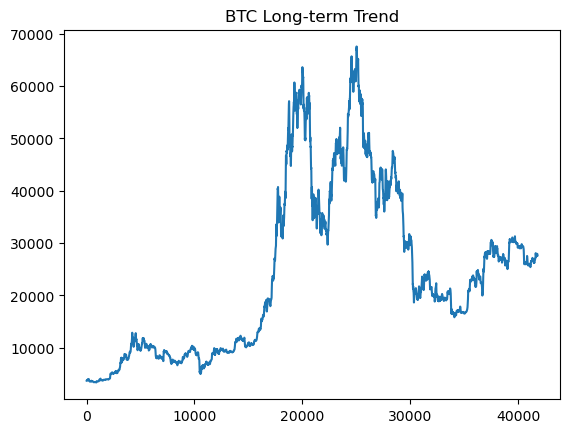

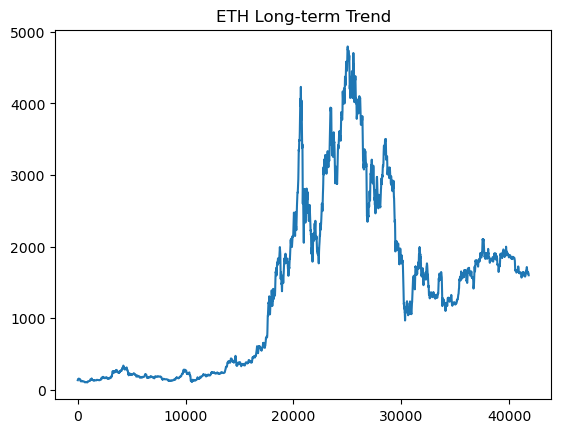

In [136]:
# ---- Trend Analysis ----
btc_decomposition = seasonal_decompose(df['close_btc'], model='multiplicative', period=24)  # assuming daily seasonality
eth_decomposition = seasonal_decompose(df['close_eth'], model='multiplicative', period=24)  # assuming daily seasonality

btc_decomposition.trend.plot(title='BTC Long-term Trend')
plt.show()

eth_decomposition.trend.plot(title='ETH Long-term Trend')
plt.show()

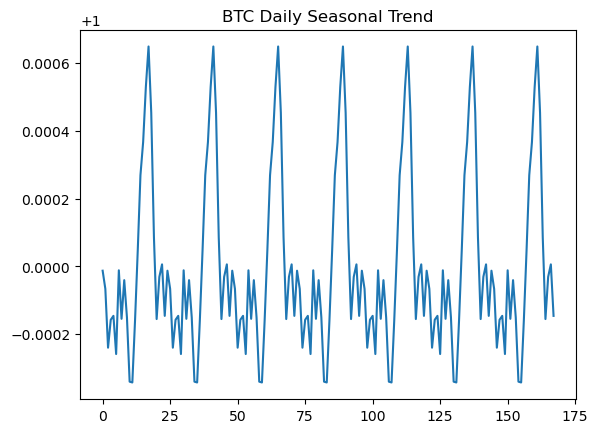

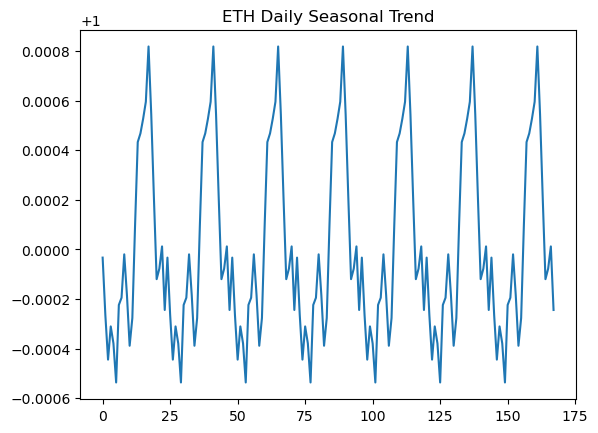

In [137]:
# Seasonal Trends:
btc_decomposition.seasonal[:24*7].plot(title='BTC Daily Seasonal Trend')  # showing 1 week of data
plt.show()

eth_decomposition.seasonal[:24*7].plot(title='ETH Daily Seasonal Trend')  # showing 1 week of data
plt.show()

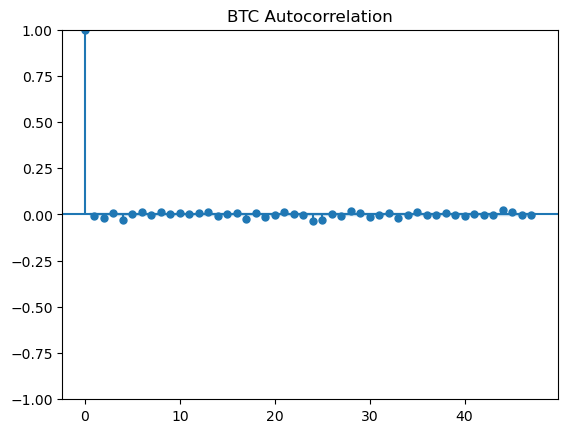

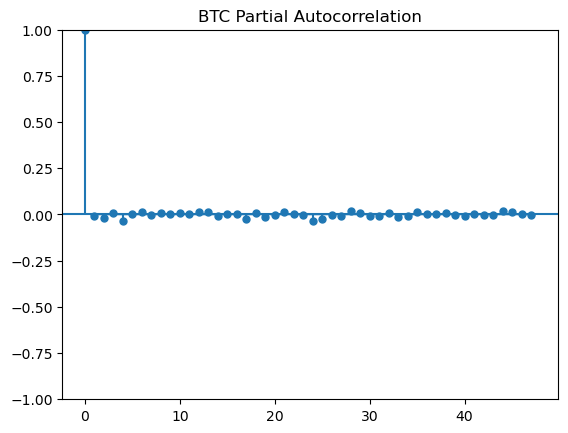

In [138]:
# ---- Autocorrelation and Partial Autocorrelation Analysis ----
plot_acf(df['close_btc'].diff().dropna())  # 1st diff is stationary 
plt.title('BTC Autocorrelation')
plt.show()

plot_pacf(df['close_btc'].diff().dropna())
plt.title('BTC Partial Autocorrelation')
plt.show()

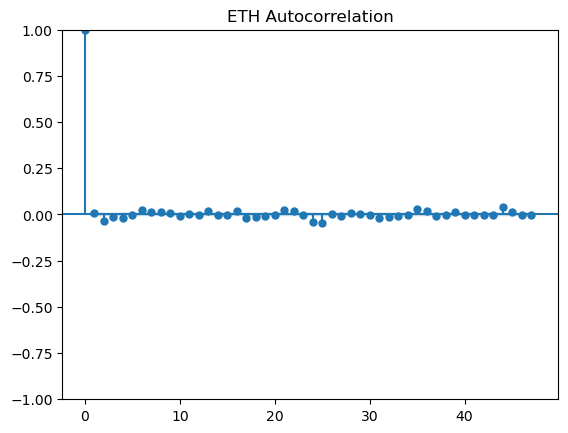

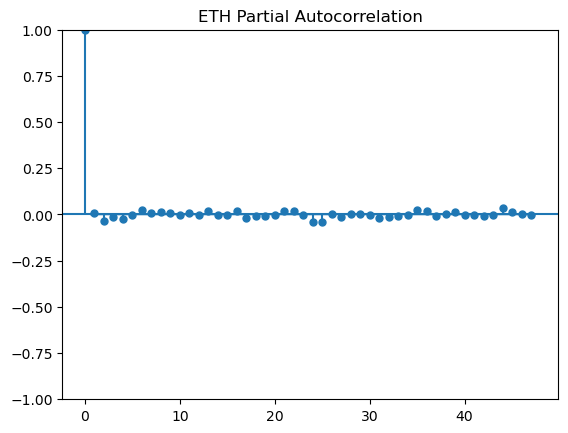

In [139]:
plot_acf(df['close_eth'].diff().dropna())  # Assuming non-stationary data, might need differencing
plt.title('ETH Autocorrelation')
plt.show()

plot_pacf(df['close_eth'].diff().dropna())
plt.title('ETH Partial Autocorrelation')
plt.show()

In [140]:
def adf_test(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    # ... further result interpretation

adf_test(df['close_btc'])
adf_test(df['close_eth'])

ADF Statistic: -1.5705459016083099
p-value: 0.4983702129353911
ADF Statistic: -1.5561220069216015
p-value: 0.5055887662674831


In [141]:
adf_test(df['close_btc'].diff())
adf_test(df['close_eth'].diff())

ADF Statistic: -29.46799082370119
p-value: 0.0
ADF Statistic: -27.10927872126234
p-value: 0.0


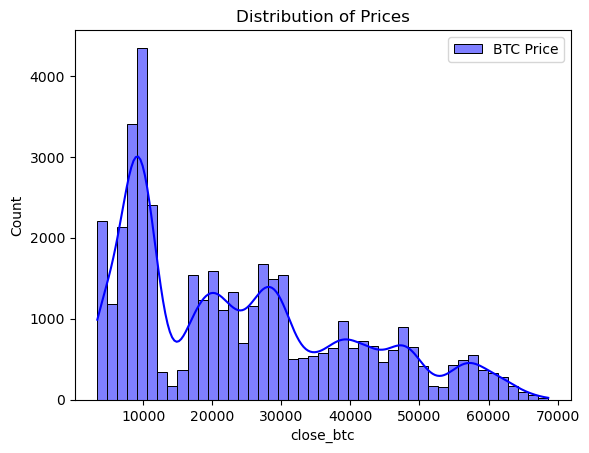

In [142]:
sns.histplot(df['close_btc'].dropna(), kde=True, color='blue', label='BTC Price')
plt.legend()
plt.title('Distribution of Prices')
plt.show()

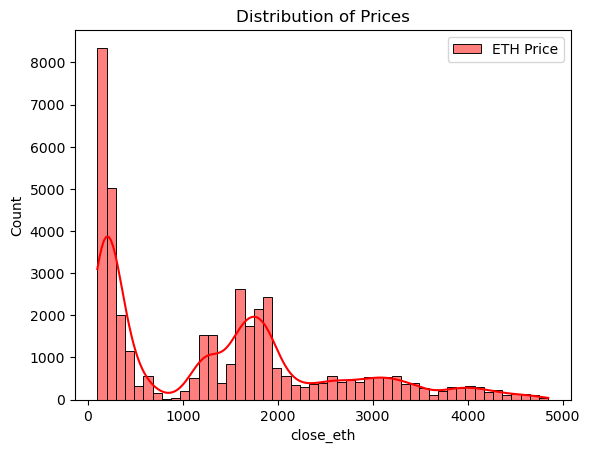

In [143]:
sns.histplot(df['close_eth'].dropna(), kde=True, color='red', label='ETH Price')
plt.legend()
plt.title('Distribution of Prices')
plt.show()

In [144]:
btc_returns = df['close_btc'].pct_change()
eth_returns = df['close_eth'].pct_change()

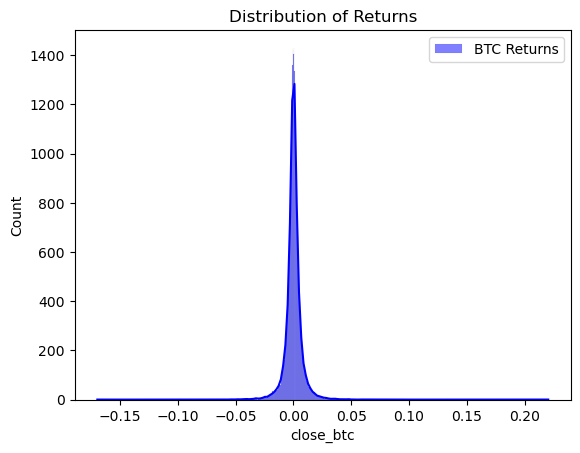

In [145]:
sns.histplot(btc_returns.dropna(), kde=True, color='blue', label='BTC Returns')
plt.legend()
plt.title('Distribution of Returns')
plt.show()

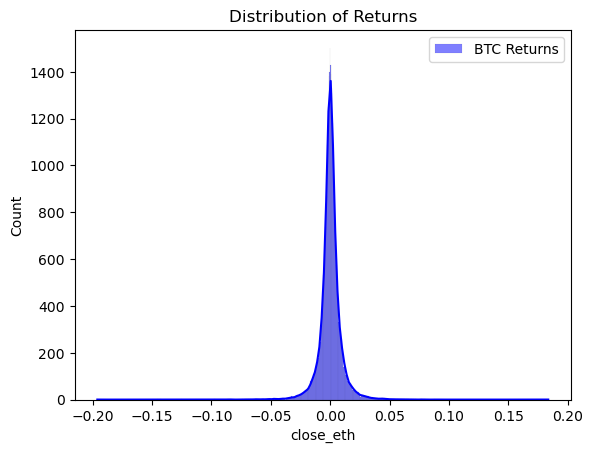

In [146]:
sns.histplot(eth_returns.dropna(), kde=True, color='blue', label='BTC Returns')
plt.legend()
plt.title('Distribution of Returns')
plt.show()

In [147]:
"""Create a feature pane"""

'Create a feature pane'

In [148]:
df['target'] = df['close_btc'].shift(-1) - df['close_btc']
df['target_1'] = df['target'].shift(1)
df = df.dropna()

In [149]:
df['spread_btc_eth'] = df['close_btc'] - df['close_eth']

In [150]:
rsi_columns = ['volume_btc', 'volume_eth', 'spread_btc_eth', 'close_eth', 'close_btc', 'target_1']
bb_columns = ['volume_btc', 'volume_eth', 'spread_btc_eth', 'close_eth', 'close_btc', 'target_1']
return_columns = ['volume_btc', 'volume_eth', 'spread_btc_eth', 'close_eth', 'close_btc', 'target_1']

rsi_periods = [7, 9, 11, 13, 15, 20]
bb_window = [5, 10, 15, 20, 25, 30]

In [151]:
features_for_ema = ['volume_btc', 'volume_eth', 'spread_btc_eth', 'close_eth', 'close_btc', 'target_1']
ema_windows = [3, 5, 10, 15, 20, 50, 100, 1000, 10000]

ema_halflife = {"100us": 1e5,
                "1ms": 1e6,
                "10ms": 1e7,
                "100ms": 1e8,
                "1s": 1e9,
                "10s": 1e10,
                "60s": 6e10,
                "1h": 3.6e12}

In [152]:
lags = [1, 2, 3, 5, 10, 20, 30, 50]
for lag in lags:
    for column in return_columns:
        df[f'return_{lag}_{column}'] = (df[f'{column}']
                               .pct_change(lag)
                               )

In [153]:
from pykalman import KalmanFilter
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

In [154]:
kalman_columns = ['volume_btc', 'volume_eth', 'spread_btc_eth', 'close_eth', 'close_btc']
for column in kalman_columns:
    state_means, _ = kf.filter(df[f'{column}'])
    df[f'{column}_kalman'] = state_means

In [155]:
df['timestamp'] = pd.to_datetime(df['time']).view('int64')
df = calulate_halflife_features_for_dataframe(df)
df = calulate_ema_window_features_for_dataframe(df)

In [156]:
for column in bb_columns:
    for period in bb_window:
        df = calculate_bb(bollinger_band_period=period, column=column, df=df)

In [157]:
for column in rsi_columns:
    for period in rsi_periods:
        df = calculate_RSI(rsi_period=period, column=column, df=df)

In [158]:
for column in df.columns:
    if ('ema' in column) and ('diff' not in column):
        df[column + '_ratio'] = df[column[:column.find('ema')-1]] / df[column]

In [159]:
for column in df.columns:
    if ('kalman' in column):
        df[column + '_diff'] = df[column[:column.find('kalman')-1]] - df[column]

In [160]:
rolling_std_columns = ['volume_btc', 'volume_eth', 'spread_btc_eth', 'close_eth', 'close_btc']
periods = [2, 5, 10, 20, 30, 50]
for column in rolling_std_columns:
    for period in periods:
        df[f'{column}_std_{period}'] = df[f'{column}'].rolling(period).std()

In [161]:
sma_periods = [2, 5, 10, 20, 30, 50]
for period in sma_periods:
    period_sma = df['close_btc'].rolling(period).mean()
    period_sma = period_sma.pct_change()
    df[f'rate_of_change_sma_vs_spread_{period}'] = df['return_1_close_btc'] / period_sma

In [162]:
df = df.dropna()
time = df.pop('time')
timestamp = df.pop('timestamp')

In [163]:
""" Feature selection """

' Feature selection '

In [39]:
abs(df.corr()['target']).nlargest(20).index.tolist()

['target',
 'spread_btc_eth_std_2',
 'close_btc_std_2',
 'return_5_close_btc',
 'return_5_spread_btc_eth',
 'return_5_close_eth',
 'return_2_spread_btc_eth',
 'return_2_close_btc',
 'close_eth_std_2',
 'close_btc_ema_window_3_ratio',
 'spread_btc_eth_ema_window_3_ratio',
 'close_eth_kalman_diff',
 'spread_btc_eth_ema_halflife_1h_ratio',
 'close_btc_ema_halflife_1h_ratio',
 'target_1_ema_window_3',
 'return_50_target_1',
 'target_1_5_BB_down',
 'return_30_close_eth',
 'volume_eth_std_2',
 'close_btc_ema_window_5_ratio']

In [164]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

In [165]:
def get_scaled_train_test_data(df, shuffle=True, xgb=False, split=0.95):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    if xgb:
        scaler = scaler.fit(df.values[:, 0: -1])
        train_scaled = scaler.transform(df.values[:, 0: -1])
        x_scaled, y_scaled = train_scaled, df.values[:, -1]
    else:
        scaler = scaler.fit(df.values.reshape(df.values.shape[0], df.values.shape[1]))
        train_scaled = scaler.transform(df.values)
        x_scaled, y_scaled = train_scaled[:, 0: -1], train_scaled[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(x_scaled, y_scaled, shuffle=shuffle, train_size=split,
                                                    random_state=42)# df_sorted.to_csv('balanced.csv')
    return scaler, X_train, X_test, y_train, y_test

In [166]:
y = df.pop('target')
df['y'] = y

In [167]:
df = df.drop(columns = df.columns[df.isin([float('inf')]).any()].tolist())

In [168]:
scaler, X_train, X_test, y_train, y_test = get_scaled_train_test_data(df=df)

In [ ]:
""" 1st feature selection test """

In [46]:
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(f_regression, k=10)
X_new = selector.fit_transform(X_train, y_train)
selected_features = df.columns[:-1][selector.get_support()]
selected_features

In [49]:
""" 2nd feature selection test """

In [50]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

estimator = LinearRegression()
selector = RFECV(estimator, cv=5)
selector.fit(X_train, y_train)

selected_features = df.columns[:-1][selector.support_][:15]

selected_features

RFECV(cv=5, estimator=LinearRegression())

In [ ]:
""" 3rd feature selection test """

In [169]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

selected_features = df.columns[:-1][lasso.coef_ != 0]
selected_features

Index([], dtype='object')

In [170]:
# This staff is great, but calculation time is too long
'''
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train[:round(X_train.shape[0]/2), :], y_train[:round(y_train.shape[0]/2)])

importances = rf.feature_importances_

selected_features = df.columns[:-1][np.argsort(importances)[::-1]][:15]

selected_features
'''

'\nfrom sklearn.ensemble import RandomForestRegressor\n\nrf = RandomForestRegressor()\nrf.fit(X_train[:round(X_train.shape[0]/2), :], y_train[:round(y_train.shape[0]/2)])\n\nimportances = rf.feature_importances_\n\nselected_features = df.columns[:-1][np.argsort(importances)[::-1]][:15]\n\nselected_features\n'

In [171]:
# Setting test and train data, mainly for walk-forward validation

In [172]:
df['date'] = time
df_train_only = df[df['date'] < '2023-06-09']
df_test_only = df[df['date'] >= '2023-06-09']
df_train_only = df_train_only.drop(columns=['date'])
df_test_only = df_test_only.drop(columns=['date'])

In [202]:
''' Creating a set of models '''

' Creating a set of models '

In [173]:
# 1st feature set

In [174]:
list_of_features=['spread_btc_eth_std_2',
 'close_btc_std_2',
 'return_5_close_btc',
 'return_5_spread_btc_eth',
 'return_5_close_eth',
 'return_2_spread_btc_eth',
 'return_2_close_btc']

df_easy_predict = get_predict_data_frame(df=df_train_only, list_of_features=list_of_features, target_value = 'y')
df_easy_test = get_predict_data_frame(df=df_test_only, list_of_features=list_of_features, target_value = 'y')
scaler, X_train, X_test, y_train, y_test = get_scaled_train_test_data(df=df_easy_predict, split=0.8)

In [175]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn import utils


import optuna
from sklearn.model_selection import cross_val_score

In [176]:
def objective(trial):
    max_depth = trial.suggest_int("max_depth", 1, df_easy_predict.shape[1], log=True)
    max_samples = trial.suggest_float("max_samples", 0.2, 0.8, log=True)
    est = trial.suggest_int("n_estimators", 2, df_easy_predict.shape[1], step=1)

    rf_model = RandomForestRegressor(
        max_depth=max_depth,
        max_samples=max_samples,
        n_estimators=est,
        random_state=42
    )
    
    rf_model.fit(X_train, y_train)
    
    y_pred = rf_model.predict(X_test)
    
    rmse = mean_squared_error(y_test, y_pred)
 
    return rmse

study = optuna.create_study(direction='minimize')  # We minimize the negative RMSE
study.optimize(objective, n_trials=20)

best_trial = study.best_trial
print("Best Trial:")
print("  RMSE:", -best_trial.value)  # Reverse the sign to get the best RMSE
print("  Params:", best_trial.params)

[I 2023-10-22 15:17:35,890] A new study created in memory with name: no-name-e22b0485-0938-4c17-8ac8-8199f3755442
[I 2023-10-22 15:17:36,024] Trial 0 finished with value: 0.0032031925386466283 and parameters: {'max_depth': 2, 'max_samples': 0.3048182785570122, 'n_estimators': 7}. Best is trial 0 with value: 0.0032031925386466283.
[I 2023-10-22 15:17:36,113] Trial 1 finished with value: 0.0032066800273465573 and parameters: {'max_depth': 3, 'max_samples': 0.3583351476276231, 'n_estimators': 3}. Best is trial 0 with value: 0.0032031925386466283.
[I 2023-10-22 15:17:36,173] Trial 2 finished with value: 0.003189904795188818 and parameters: {'max_depth': 1, 'max_samples': 0.3100453933512994, 'n_estimators': 6}. Best is trial 2 with value: 0.003189904795188818.
[I 2023-10-22 15:17:36,216] Trial 3 finished with value: 0.0032875585271256017 and parameters: {'max_depth': 2, 'max_samples': 0.21596271502985825, 'n_estimators': 3}. Best is trial 2 with value: 0.003189904795188818.
[I 2023-10-22 15

Best Trial:
  RMSE: -0.003186583403262009
  Params: {'max_depth': 1, 'max_samples': 0.30846178647597405, 'n_estimators': 2}


In [177]:
model_rf = RandomForestRegressor(**study.best_trial.params)
model_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=1, max_samples=0.30846178647597405,
                      n_estimators=2)

In [178]:
# Train results
print('Train resuts')
pred_df = rescale_predict_measure_accuracy(model=model_rf, scaler=scaler, frame_to_predict=X_train, real_y=y_train)
# Test results
print('Test resuts')
scaled_test = scaler.transform(df_easy_test.values)
X_scaled_test = scaled_test[:, 0: -1]
y_scaled_test = scaled_test[:, -1]
pred_df = rescale_predict_measure_accuracy(model=model_rf, scaler=scaler, frame_to_predict=X_scaled_test, real_y=y_scaled_test)

Train resuts
Evaluation Results:
MAE: 117.5173
MSE: 52511.5616
Std of Error: 229.1525
Test resuts
Evaluation Results:
MAE: 58.8321
MSE: 10348.1333
Std of Error: 101.7255


<Axes: >

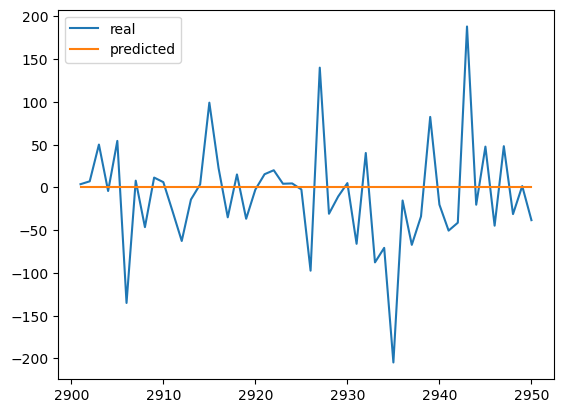

In [180]:
pred_df.iloc[-50:].plot()

In [181]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

# Train results
print('Train resuts')
pred_df = rescale_predict_measure_accuracy(model=model, scaler=scaler, frame_to_predict=X_train, real_y=y_train)
# Test results
print('Test resuts')
scaled_test = scaler.transform(df_easy_test.values)
X_scaled_test = scaled_test[:, 0: -1]
y_scaled_test = scaled_test[:, -1]
pred_df = rescale_predict_measure_accuracy(model=model, scaler=scaler, frame_to_predict=X_scaled_test, real_y=y_scaled_test)

Train resuts
Evaluation Results:
MAE: 117.1741
MSE: 51940.5876
Std of Error: 227.9048
Test resuts
Evaluation Results:
MAE: 58.6710
MSE: 10322.1409
Std of Error: 101.5808


<Axes: >

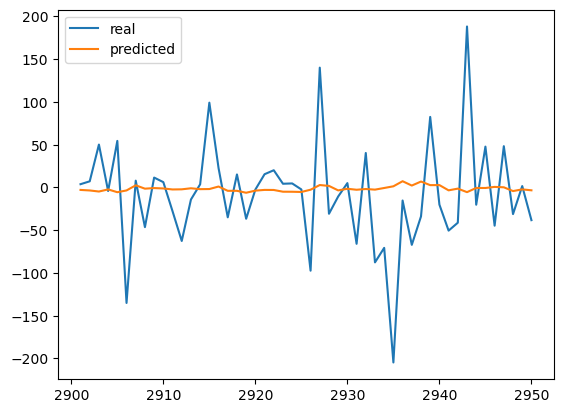

In [182]:
pred_df.iloc[-50:].plot()

In [183]:
# Reducing multicollinearity for LinearRegression

In [184]:
correlation_matrix = df_easy_predict.drop(columns = ['y']).corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.75)]
df_reduced = df_easy_predict.drop(df_easy_predict[to_drop], axis=1)

list_of_features = df_reduced.drop(columns=['y']).columns.tolist()

df_easy_predict = get_predict_data_frame(df=df_train_only, list_of_features=list_of_features, target_value = 'y')
df_easy_test = get_predict_data_frame(df=df_test_only, list_of_features=list_of_features, target_value = 'y')
scaler, X_train, X_test, y_train, y_test = get_scaled_train_test_data(df=df_easy_predict, split=0.8)

In [185]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

# Train results
print('Train resuts')
pred_df = rescale_predict_measure_accuracy(model=model, scaler=scaler, frame_to_predict=X_train, real_y=y_train)
# Test results
print('Test resuts')
scaled_test = scaler.transform(df_easy_test.values)
X_scaled_test = scaled_test[:, 0: -1]
y_scaled_test = scaled_test[:, -1]
pred_df = rescale_predict_measure_accuracy(model=model, scaler=scaler, frame_to_predict=X_scaled_test, real_y=y_scaled_test)

Train resuts
Evaluation Results:
MAE: 117.1780
MSE: 51954.7299
Std of Error: 227.9358
Test resuts
Evaluation Results:
MAE: 58.6810
MSE: 10324.2176
Std of Error: 101.5896


<Axes: >

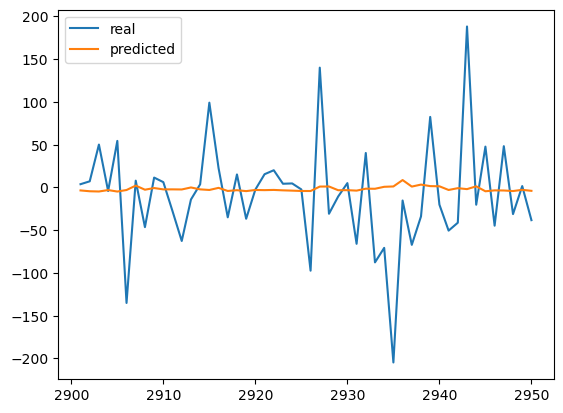

In [186]:
pred_df.iloc[-50:].plot()

In [187]:
# 2nd set of features

In [188]:
list_of_features=['return_5_spread_btc_eth', 'return_5_close_eth', 'return_5_close_btc',
       'spread_btc_eth_ema_halflife_1h_ratio',
       'close_btc_ema_halflife_1h_ratio', 'spread_btc_eth_ema_window_3_ratio',
       'close_btc_ema_window_3_ratio', 'volume_eth_std_2',
       'spread_btc_eth_std_2', 'close_btc_std_2']

df_easy_predict = get_predict_data_frame(df=df_train_only, list_of_features=list_of_features, target_value = 'y')
df_easy_test = get_predict_data_frame(df=df_test_only, list_of_features=list_of_features, target_value = 'y')
scaler, X_train, X_test, y_train, y_test = get_scaled_train_test_data(df=df_easy_predict, split=0.8)

In [189]:
def objective(trial):
    max_depth = trial.suggest_int("max_depth", 1, df_easy_predict.shape[1], log=True)
    max_samples = trial.suggest_float("max_samples", 0.2, 0.8, log=True)
    est = trial.suggest_int("n_estimators", 2, df_easy_predict.shape[1], step=1)

    rf_model = RandomForestRegressor(
        max_depth=max_depth,
        max_samples=max_samples,
        n_estimators=est,
        random_state=42
    )
    
    rf_model.fit(X_train, y_train)
    
    y_pred = rf_model.predict(X_test)
    
    rmse = mean_squared_error(y_test, y_pred)
 
    return rmse

study = optuna.create_study(direction='minimize')  # We minimize the negative RMSE
study.optimize(objective, n_trials=20)

best_trial = study.best_trial
print("Best Trial:")
print("  RMSE:", -best_trial.value)  # Reverse the sign to get the best RMSE
print("  Params:", best_trial.params)

[I 2023-10-22 15:18:56,912] A new study created in memory with name: no-name-e4501028-e0f9-4cb4-b27e-db481abf4581
[I 2023-10-22 15:18:57,177] Trial 0 finished with value: 0.003216824189365959 and parameters: {'max_depth': 3, 'max_samples': 0.30815337498625384, 'n_estimators': 7}. Best is trial 0 with value: 0.003216824189365959.
[I 2023-10-22 15:18:57,599] Trial 1 finished with value: 0.0031941994772580044 and parameters: {'max_depth': 4, 'max_samples': 0.2726511684405243, 'n_estimators': 10}. Best is trial 1 with value: 0.0031941994772580044.
[I 2023-10-22 15:18:57,698] Trial 2 finished with value: 0.003191026578417823 and parameters: {'max_depth': 1, 'max_samples': 0.38324053973010536, 'n_estimators': 6}. Best is trial 2 with value: 0.003191026578417823.
[I 2023-10-22 15:18:58,445] Trial 3 finished with value: 0.0032833645616663896 and parameters: {'max_depth': 10, 'max_samples': 0.2468342429553711, 'n_estimators': 8}. Best is trial 2 with value: 0.003191026578417823.
[I 2023-10-22 1

Best Trial:
  RMSE: -0.0031843485637675305
  Params: {'max_depth': 2, 'max_samples': 0.6131982462512865, 'n_estimators': 5}


In [190]:
model_rf = RandomForestRegressor(**study.best_trial.params)
model_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, max_samples=0.6131982462512865,
                      n_estimators=5)

In [191]:
# Train results
print('Train resuts')
pred_df = rescale_predict_measure_accuracy(model=model_rf, scaler=scaler, frame_to_predict=X_train, real_y=y_train)
# Test results
print('Test resuts')
scaled_test = scaler.transform(df_easy_test.values)
X_scaled_test = scaled_test[:, 0: -1]
y_scaled_test = scaled_test[:, -1]
pred_df = rescale_predict_measure_accuracy(model=model_rf, scaler=scaler, frame_to_predict=X_scaled_test, real_y=y_scaled_test)

Train resuts
Evaluation Results:
MAE: 117.3162
MSE: 51541.4997
Std of Error: 227.0268
Test resuts
Evaluation Results:
MAE: 58.7492
MSE: 10307.9596
Std of Error: 101.5213


<Axes: >

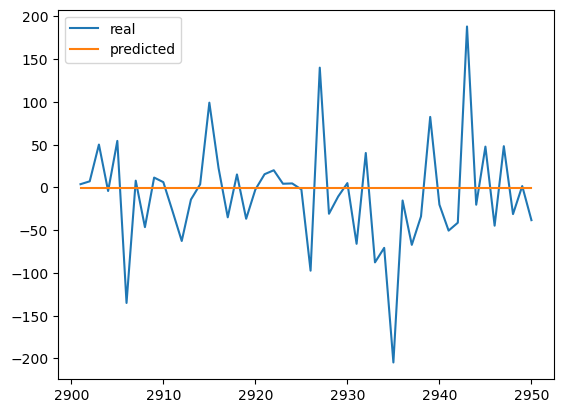

In [192]:
pred_df.iloc[-50:].plot()

In [193]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

# Train results
print('Train resuts')
pred_df = rescale_predict_measure_accuracy(model=model, scaler=scaler, frame_to_predict=X_train, real_y=y_train)
# Test results
print('Test resuts')
scaled_test = scaler.transform(df_easy_test.values)
X_scaled_test = scaled_test[:, 0: -1]
y_scaled_test = scaled_test[:, -1]
pred_df = rescale_predict_measure_accuracy(model=model, scaler=scaler, frame_to_predict=X_scaled_test, real_y=y_scaled_test)

Train resuts
Evaluation Results:
MAE: 117.2966
MSE: 51889.7942
Std of Error: 227.7933
Test resuts
Evaluation Results:
MAE: 58.6457
MSE: 10323.2489
Std of Error: 101.6033


<Axes: >

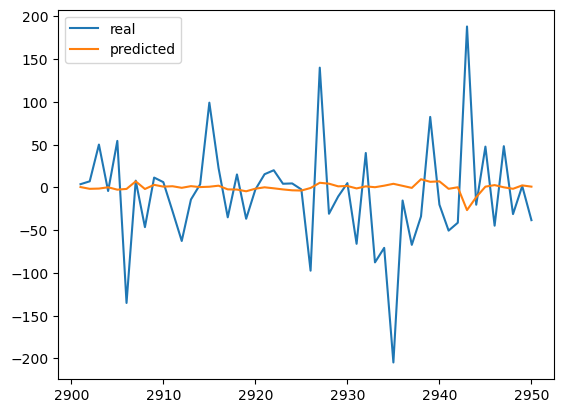

In [194]:
pred_df.iloc[-50:].plot()

In [195]:
# Reducing multicollinearity for LinearRegression

In [196]:
correlation_matrix = df_easy_predict.drop(columns = ['y']).corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.75)]
df_reduced = df_easy_predict.drop(df_easy_predict[to_drop], axis=1)

list_of_features = df_reduced.drop(columns=['y']).columns.tolist()

df_easy_predict = get_predict_data_frame(df=df_train_only, list_of_features=list_of_features, target_value = 'y')
df_easy_test = get_predict_data_frame(df=df_test_only, list_of_features=list_of_features, target_value = 'y')
scaler, X_train, X_test, y_train, y_test = get_scaled_train_test_data(df=df_easy_predict, split=0.8)

In [197]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

# Train results
print('Train resuts')
pred_df = rescale_predict_measure_accuracy(model=model, scaler=scaler, frame_to_predict=X_train, real_y=y_train)
# Test results
print('Test resuts')
scaled_test = scaler.transform(df_easy_test.values)
X_scaled_test = scaled_test[:, 0: -1]
y_scaled_test = scaled_test[:, -1]
pred_df = rescale_predict_measure_accuracy(model=model, scaler=scaler, frame_to_predict=X_scaled_test, real_y=y_scaled_test)

Train resuts
Evaluation Results:
MAE: 117.2993
MSE: 51913.4556
Std of Error: 227.8452
Test resuts
Evaluation Results:
MAE: 58.6116
MSE: 10319.5350
Std of Error: 101.5850


<Axes: >

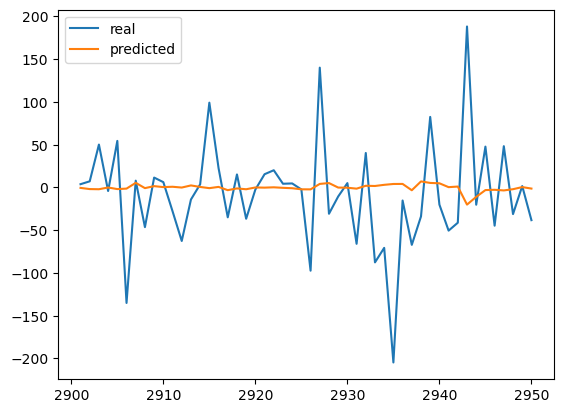

In [198]:
pred_df.iloc[-50:].plot()

In [199]:
""" Arima model """

' Arima model '

In [121]:
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

predictions = []
actuals = []

train_data = df_train_only['y']
test_data = df_test_only.iloc[:200]['y'] # Just to make it faster

predictions = []
for i in range(0, len(test_data)+1):
    p, d, q = 1, 1, 1  # Not much PACF since p = 1, I made 1st order difference since d=1, as well as not much ACF observed q = 1, Plots are in the EDA part
    if i == 0:
        model = ARIMA(train_data, order=(p, d, q))
        results_arima = model.fit()
        pred = results_arima.forecast(steps=1).values[0]
    else:
        model = ARIMA(np.append(train_data.values, test_data.iloc[i-1]), order=(p, d, q))
        results_arima = model.fit()
        pred = results_arima.forecast(steps=1)[0]
    predictions.append(pred)

' Думаю, я тут зробив помилку, мої результати ніколи не були такі різні '

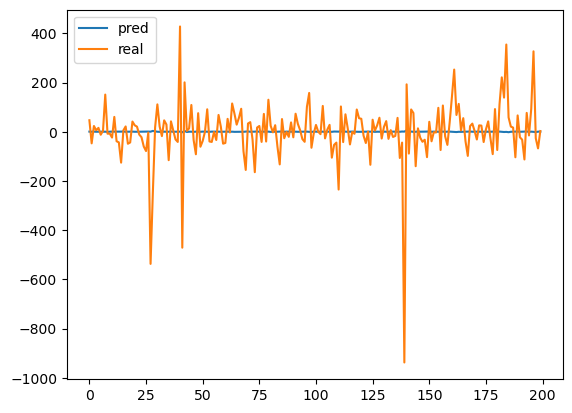

In [131]:
pd.DataFrame({'pred': predictions[:-1],
              'real': test_data.values}).plot()
''' Думаю, я тут зробив помилку, мої результати ніколи так не різнились '''

In [203]:
""" Results """

' Results '

In [200]:
"""
Порівняння моделей: 

ARIMA
Переваги:

Інтерпретованість: моделі ARIMA відносно легко інтерпретувати, оскільки вони базуються на добре зрозумілих статистичних властивостях даних.
Ефективність: вони є простішими в обчисленні порівняно з деякими складними моделями машинного навчання.
Включення минулої інформації: ARIMA використовує минулі значення та помилки для роботи прогнозів, що робить його підходящим для часових рядів з трендами та/або сезонними відмінностями.
Налаштування: пропонує параметри для контролю за сезонністю та трендом.

Недоліки:

Припущення лінійності: припускає лінійні відносини між змінними, які можуть не враховувати складні відносини.
Статичність: вимагає, щоб дані були стаціонарними.
Відсутність зовнішніх факторів: не може легко інтегрувати зовнішні фактори або змінні.

Random Forest:
Переваги:

Нелінійність: фіксує нелінійні відносини в даних, що є корисним у складних реальних сценаріях.
Регуляризація: включає регуляризацію для уникнення перенавчання.
Паралельна обробка: використовує паралельну обробку, роблячи його швидшим, ніж багато інших алгоритмів.
Мінімальна Підготовка Даних: Потребує мало підготовки даних - наприклад, немає потреби трансформувати змінні або видаляти викиди.
Стійкість до викидів в даних: Випадковий ліс менш чутливий до викидів у даних.

Недоліки:

Інтерпретованість: менш інтерпретований порівняно з лінійними моделями, особливо зі збільшенням складності моделі.
Необхідна настройка: вимагає обережної настройки гіперпараметрів для отримання хорошої продуктивності.
Обчислювальна інтенсивність: може бути обчислювально інтенсивним і споживати багато пам'яті для великих наборів даних.
Обмеження відносного тренувального набору данних та межі прийняття рішень: Якщо значення прогнозованого "у" в тестовому наборі данних буде виходити за значення тренувальної проби даних, 
RF не зможе екстраполювати за тренувальну пробу, так само це призводить до додаткового згладжування.

Лінійна регресія:
Переваги:

Простота: легко розуміти, впроваджувати та інтерпретувати.
Інтерпретованість: надає інтерпретовані коефіцієнти моделі для кожної функції.
Ефективність: обчислювально ефективний та швидкий для навчання.
Можливість експраполяції без необхідності перенавчання.

Недоліки:

Припущення про лінійність: припускає лінійний зв'язок між функціями та цільовою змінною, який може не завжди відповідати істині.
Чутливість до викидів даних: викиди даних можуть значно вплинути на продуктивність моделі.
Відсутність гнучкості: не може враховувати складні відносини в даних або обробляти нелінійності без трансформацій або додаткового створення функцій.
"""

'\nПорівняння моделей: \n\nARIMA\nПереваги:\n\nІнтерпретованість: моделі ARIMA відносно легко інтерпретувати, оскільки вони базуються на добре зрозумілих статистичних властивостях даних.\nЕфективність: вони є простішими в обчисленні порівняно з деякими складними моделями машинного навчання.\nВключення минулої інформації: ARIMA використовує минулі значення та помилки для роботи прогнозів, що робить його підходящим для часових рядів з трендами та/або сезонними відмінностями.\nНалаштування: пропонує параметри для контролю за сезонністю та трендом.\n\nНедоліки:\n\nПрипущення лінійності: припускає лінійні відносини між змінними, які можуть не враховувати складні відносини.\nСтатичність: вимагає, щоб дані були стаціонарними.\nВідсутність зовнішніх факторів: не може легко інтегрувати зовнішні фактори або змінні.\n\nRandom Forest:\nПереваги:\n\nНелінійність: фіксує нелінійні відносини в даних, що є корисним у складних реальних сценаріях.\nРегуляризація: включає регуляризацію для уникнення пере

In [201]:
"""
Висновок:
На жаль, або на щастя, лінійна регресія в даному випадку показала, кращий результат через її прогнози мають більш варіативні результати від RF, 
через усереднення самого RF, а саме структури меж прийняття рішень, що призводять до усереднення, вони призводять до більш гладких прогнозів 
порівняно з часто жорсткими лінійними межами прийняття рішень лінійної регресії, саме тому на графіках вище прогнози RF зводяться до нуля.

Основна проблема в тому, на мою думку, в тому, що дана часова гранулярність майже не має автокореляції ряду t і t-1, враховучи відсутність інших даних, 
ми можемо покладатись тільки на це. Все ж вважаю, що навіть при такому можна показати кращий результат за наявності більшого досвіду і кращих навичок. 
"""

'\nВисновок:\nНа жаль, або на щастя, лінійна регресія в даному випадку показала, кращий результат через її прогнози мають кращий результати від RF, \nчерез усереднення самого RF, а саме структури меж прийняття рішень, що призводять до усереднення, вони призводять до більш гладких прогнозів \nпорівняно з часто жорсткими лінійними межами прийняття рішень лінійної регресії, саме тому на графіках вище прогнози RF зводяться до нуля.\nпроблема в тому, на мою думку, в тому, що дана часова гранулярність майже не має автокореляції ряду t і t-1. \nМожливо я не правий і при даних вводних можна витиснути більше\n'